Ce TP est une illustration des méthodes de diffusion permettant la génération d'image. Il reprend les éléments présentés dans l'article **Denoising Diffusion Probabilistic Models** de Jonathan Ho et al. paru en 2020, simplifié pour être réalisable en une séance de TP.

In [2]:
import tensorflow
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import math

# Chargement des données

Pour ce TP, nous utiliserons simplement les données d'entraînement de la base de données MNIST.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Passe forward: image $ \rightarrow$ noise


Pour commencer, nous allons illustrer la passe *forward* consistant à bruiter itérativement une image jusqu'à ce qu'elle devienne une image de bruit gaussien centré réduit.


<center> <img src="https://drive.google.com/uc?id=1igVT9w15wgs-8YDFK8frhBkRkRitSRnj" width=500></center>

On procède en $T$ étapes, et à chaque étape on peut exprimer la distribution de $\boldsymbol{x}_t$ à partir de celle de $\boldsymbol{x}_{t-1}$ de la manière suivante :

$$q(\boldsymbol{x}_t \mid \boldsymbol{x}_{t-1}) = \mathcal{N}(\boldsymbol{x}_t ; \sqrt{1 - \beta_t} \, \boldsymbol{x}_{t-1}, \beta_t \boldsymbol{I}) \quad
$$


où $\beta_t$ est un paramètre qui programme l'ajout progressif de bruit.

Avec des $\beta_t$ bien choisis, les pixels de l'image suivent à l'issue du processus une loi normale centrée réduite.

Si l'on pose $\alpha_t = 1 - \beta_t$ et $\overline{\alpha}_t = \prod_{s=1}^t \alpha_s$, on peut montrer que :    

$$q(\boldsymbol{x}_T \mid \boldsymbol{x}_{0}) = \mathcal{N}(\boldsymbol{x}_T ; \sqrt{\overline{\alpha}_T} \, \boldsymbol{x}_{0}, (1 - \overline{\alpha}_T) \boldsymbol{I}) \quad$$

Le choix des hyperparamètres $T$ et $\beta_t$ est crucial pour le bon fonctionnement de l'algorithme. Dans l'article original, $T = 1000$ (!!) et les $\beta_t$ sont répartis linéairement entre $\beta_1 = 1e-4$ et $\beta_T=0.02$. Les auteurs mentionnent l'importance d'avoir des $\beta_t$ petits pour obtenir des échantillons réalistes lors de la génération.


Dans ce TP, nous allons faire des choix simplificateurs afin de pouvoir exécuter l'algorithme dans les 2h imparties. Ainsi, nous choisirons $T = 10$, et $\beta_1 = 0.1$, $\beta_T=0.8$. Nous verrons malheureusement que les échantillons que nous générerons ne serons pas parfaitement réalistes, mais cela nous permettra quand même d'avoir une preuve de concept !



In [4]:
# 10 pas de diffusion
T = 10

# Programmation des beta_t
beta_1 = 0.1
beta_T = 0.8

### A COMPLETER ###
# Les beta_t se répartissent linéairement entre beta_1 et beta_T
beta = np.concatenate((np.array([0.]), np.linspace(beta_1,beta_T,T)))
print('beta = ' + str(beta))


beta = [0.         0.1        0.17777778 0.25555556 0.33333333 0.41111111
 0.48888889 0.56666667 0.64444444 0.72222222 0.8       ]


**Résultat attendu :**
    
```
beta = [0.         0.1        0.17777778 0.25555556 0.33333333 0.41111111
 0.48888889 0.56666667 0.64444444 0.72222222 0.8       ]
 ```

**Travail à faire** : Compléter la définition des $\alpha_t$ et des $\overline{\alpha}_t$, et vérifiez que la distribution finale obtenue pour $\boldsymbol{x}_T$ est bien proche d'une loi normale centrée réduite.

In [5]:
### A COMPLETER ###
alpha = 1 - beta
alpha_barre = np.array([np.prod(alpha[:i+1]) for i in range(np.size(alpha))])

# Moyenne de x_T
mu_x_T = np.sqrt(alpha_barre[-1])
print('Moyenne de x_T = ' + str(mu_x_T))

# Variance de x_T
sigma_x_T = 1 - alpha_barre[-1]
print('Variance de x_T = ' + str(sigma_x_T))

Moyenne de x_T = 0.03076020665577701
Variance de x_T = 0.9990538096864939


**Résultat attendu :**    
```
Moyenne de x_T = 0.03076020665577701
Variance de x_T = 0.9990538096864939
```

Les images doivent être normalisées entre -1 et 1 avant de démarrer le processus de diffusion.

In [6]:
def normalize(img):
  img = img.astype('float')
  return (img-128)/128

def denormalize(img):
  img = 255*(img+np.min(img))/(np.max(img) - np.min(img))
  return img.astype('uint8')

## Diffusion progressive

Si $\boldsymbol{x}_{t-1}$ est l'image bruitée au pas $t-1$, et $\boldsymbol{\epsilon}$ un bruit échantillonné sur toute la dimension de l'image, on peut obtenir $\boldsymbol{x}_t$ en calculant :

$$
\boldsymbol{x}_t = \sqrt{\alpha_t} \, \boldsymbol{x}_{t-1} + \sqrt{\beta_t} \, \boldsymbol{\epsilon}
$$

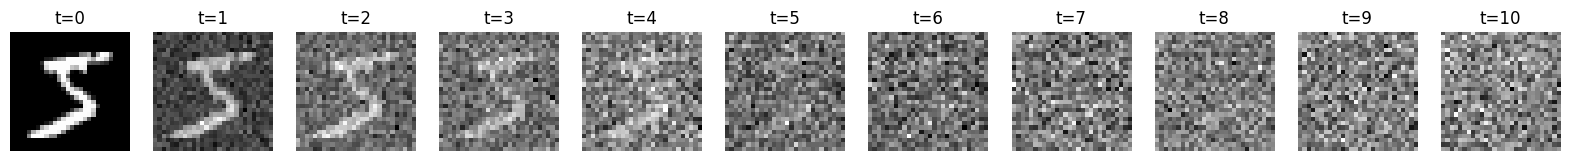

In [7]:
### A COMPLETER ###
# On prend une image de la base de donnée comme point de départ
x_0 = normalize(x_train[0])

# On prépare le vecteur des x_t que l'on va remplir au fur et à mesure
x = np.zeros((T+1, 28, 28))

plt.figure(figsize=(20, 10))

for t in range(T+1):
  if t==0:
    x[t] = x_0
  else:
    # Echantillonnage d'un bruit gaussien epsilon
    epsilon = np.random.normal(0, 1, (28, 28))

    # Calcul de x_t à partir de x_{t-1}
    x[t] = np.sqrt(alpha[t])*x[t-1] + np.sqrt(beta[t])*epsilon

  # Affichage de x_t
  plt.subplot(1, T+1, t+1)
  plt.title(f't={t}')
  plt.imshow(x[t], cmap='gray')
  plt.axis('off')

plt.show()

## Diffusion directe

Il sera plus aisé (et rapide !) pendant l'apprentissage d'obtenir directement une expression de $\boldsymbol{x}_t$ à partir de $\boldsymbol{x}_0$ grâce à la relation :     

$$q(\boldsymbol{x}_t \mid \boldsymbol{x}_{0}) = \mathcal{N}(\boldsymbol{x}_t ; \sqrt{\overline{\alpha}_t} \, \boldsymbol{x}_{0}, (1 - \overline{\alpha}_t) \boldsymbol{I}) \quad$$

Si $\boldsymbol{x}_{0}$ est l'image originale, et $\boldsymbol{\epsilon}$ un bruit échantillonné sur toute la dimension de l'image, on peut donc obtenir $\boldsymbol{x}_t$ en calculant :

$$
\boldsymbol{x}_t = \sqrt{\overline{\alpha}_t} \, \boldsymbol{x}_{0} + \sqrt{1 - \overline{\alpha}_t} \, \boldsymbol{\epsilon}
$$

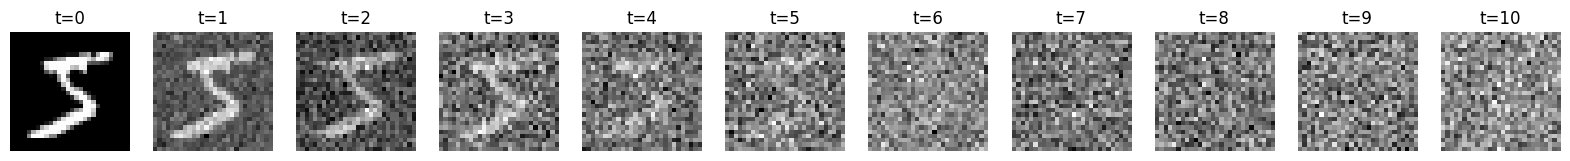

In [8]:
### A COMPLETER ###

# On prend une image de la base de donnée comme point de départ
x_0 = normalize(x_train[0])

# On prépare le vecteur des x_t que l'on va remplir au fur et à mesure
x = np.zeros((T+1, 28, 28))

plt.figure(figsize=(20, 10))

for t in range(T+1):
  if t==0:
    x[t] = x_0
  else:
    # Echantillonnage d'un bruit gaussien epsilon
    epsilon = np.random.normal(0, 1, (28, 28))

    # Calcul de x_t à partir de x_{t-1}
    x[t] = np.sqrt(alpha_barre[t])*x[0] + np.sqrt(1-alpha_barre[t])*epsilon

  # Affichage de x_t
  plt.subplot(1, T+1, t+1)
  plt.title(f't={t}')
  plt.imshow(x[t], cmap='gray')
  plt.axis('off')

plt.show()


## Entraînement du modèle

Un modèle génératif dit "de diffusion" est utilisé pour inverser le processus de bruitage itératif mis en place dans les sections précédentes.

Partant d'une image de bruit gaussien centré réduit, le modèle va estimer ce qui, dans cette image, n'est que du bruit ajouté à l'image originelle (un chiffre manuscrit). Puis on retirera une fraction de ce bruit estimé et on recommencera ce processus $T$ fois pour faire émerger l'image d'un chiffre manuscrit à partir du bruit aléatoire initial.


Pour entraîner le modèle, nous devons donc lui donner en entrée une image bruitée ainsi que le pas de temps courant, et lui faire prédire le bruit ajouté à cette image.


<center> <img src="https://drive.google.com/uc?id=1cNaxGhMFsWzdZDBJTdh2CAyKWW34T4W3" width=500></center>

Nous allons d'abord préparer les entrées ($\boldsymbol{x}_0$ et $t$) et la sortie associée ($\boldsymbol{\epsilon}$) à donner au réseau au moyen d'un objet Sequence.

Puis nous allons définir le réseau (de type U-Net) et lancer l'apprentissage.

### Mise en batches avec une Sequence

Un objet Sequence permet de réaliser la mise en batches de la base de données. A chaque itération de la descente de gradient, la fonction __getitem__() est appelée par la fonction fit() pour récupérer les entrées du batch courant, afin que les sorties correspondantes à faire prédire au réseau.

In [38]:
from tensorflow.keras.utils import Sequence

### A COMPLETER ###
class DiffusionSequence(Sequence):
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_set, batch_size, beta):
        self.x = x_set
        self.batch_size = batch_size
        self.indices = np.arange(x_set.shape[0])
        self.beta = beta
        self.alpha = alpha
        self.alpha_barre = alpha_barre
        np.random.shuffle(self.indices) # Les indices permettent d'accéder
        # aux données sont randomisés à chaque epoch pour varier la composition
        # des batches au cours de l'entraînement

    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int(np.floor(len(self.x) / float(self.batch_size)))


    # Fonction appelée à chaque nouveau batch : préparation des données et labels associés
    # On va appliquer la diffusion directe à des images de la base de donnée
    # Pour cela nous allons générer des bruits epsilon, qui seront les cibles (batch_y)
    # Pour chaque image, nous allons tirer aléatoirement un pas t entre 1 et T et
    # générer l'image bruitée x_t correspondante à l'aide du epsilon
    def __getitem__(self, idx):

        # La cible à prédire sera un bruit gaussien centré réduit de taille (B, 28, 28)
        batch_y = np.random.normal(0, 1, (self.batch_size, 28, 28))

        # Sélection des images dans la base
        batch_x = self.x[self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]].astype('float')
        batch_x = normalize(batch_x)

        # Echantillonnage de t entre 1 et T
        batch_t = np.random.randint(1, T, size=self.batch_size)

        for i in range(self.batch_size):
          # Pour chaque élément de batch_x, on remplace l'image originale (x_0) par
          # l'image bruitée générée (x_t)
          batch_x[i] = np.sqrt(alpha_barre[batch_t[i]])*batch_x[i] + np.sqrt(1-alpha_barre[batch_t[i]])*batch_y[i]

        # On normalise les t qui seront fournis à l'entrée du réseau
        batch_t = batch_t/T

        # On retourne les entrées à fournir au réseau (batch_x, batch_t) et la sortie batch_y
        return ((np.array(batch_x), batch_t), np.array(batch_y))

    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices)



Instanciation de la séquence et affichage d'un couple donnée/label

In [54]:
train_gen = DiffusionSequence(x_train, 32, beta)

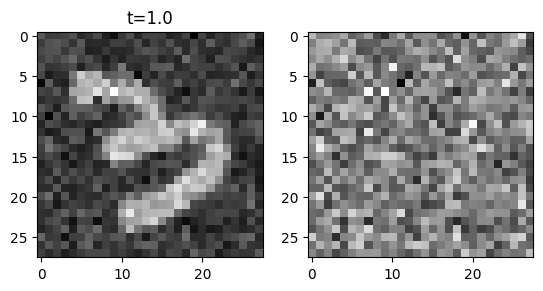

In [58]:
x, batch_y = train_gen.__getitem__(0)
batch_x, batch_t = x

plt.subplot(1,2,1)
plt.imshow(batch_x[0], cmap='gray')
plt.title(f't={batch_t[0]*T}')

plt.subplot(1,2,2)
plt.imshow(batch_y[0], cmap='gray')

plt.show()

### Création du modèle

Pour cette partie je vous fournis un modèle qui devrait suffire pour générer les chiffres manuscrits; ce modèle prend deux entrées $x_t$ et $t$ !

In [59]:
from keras.layers import Conv2D, Input, MaxPooling2D, Conv2DTranspose, concatenate, Dense, Reshape
from keras.models import Model

def create_unet(image_size=28):
  input_image=Input((image_size, image_size, 1))
  input_step = Input((1,))

  step_preproc = Dense(image_size*image_size, activation='relu')(input_step)
  step_preproc = Reshape((image_size, image_size, 1))(step_preproc)

  input_layer = concatenate([input_image, step_preproc], axis=3)

  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_image)
  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

  up4 = Conv2DTranspose(64, 2, 2, padding='same', activation='relu')(conv3)
  merge4 = concatenate([conv2,up4], axis = 3)
  conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
  conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)

  up5 = Conv2DTranspose(32, 2, 2, padding='same', activation='relu')(conv4)
  merge5 = concatenate([conv1,up5], axis = 3)
  conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)
  conv5 = Conv2D(1, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(conv5)

  model = Model(inputs=[input_image, input_step], outputs=conv5)

  return model

In [60]:
model = create_unet()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 28, 28,    │        320 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 28, 28,    │      9,248 │ conv2d_30[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 14, 14,    │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 14, 14,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 14, 14,    │     36,928 │ conv2d_32[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 7, 7, 64)  │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 7, 7, 128) │     73,856 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 7, 7, 128) │    147,584 │ conv2d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 14, 14,    │     32,832 │ conv2d_35[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 14, 14,    │          0 │ conv2d_33[0][0],  │
│ (Concatenate)       │ 128)              │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 14, 14,    │     73,792 │ concatenate_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 14, 14,    │     36,928 │ conv2d_36[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 28, 28,    │      8,224 │ conv2d_37[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 28, 28,    │          0 │ conv2d_31[0][0],  │
│ (Concatenate)       │ 64)               │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 28, 28,    │     18,464 │ concatenate_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 456,705 (1.74 MB)

 Trainable params: 456,705 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

### Entraînement du modèle

In [61]:
model = create_unet()
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=opt)

train_gen = DiffusionSequence(x_train, 32, beta)

model.fit(train_gen, epochs=20)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.1262
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0390
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0342
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0319
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0306
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0301
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0295
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0288
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0285
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0279
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0277
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0278
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0272
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0274
Epoch 15/20
1875/1875 ━━━━

# Passe backward: noise -> image

Dans cette partie, nous allons nous servir de la prédiction du réseau pour débruiter itérativement une image de bruit et arriver, on l'espère, à générer une image.

Pour commencer, nous allons vérifier si le bruit $\boldsymbol{\epsilon}_\theta (\boldsymbol{x}_t, t)$ prédit par le réseau est pertinent.

Pour cela, nous allons générer des images bruitées $\boldsymbol{x}_t$ comme précédemment.
Pour chaque image, nous allons faire estimer le bruit par le réseau, et essayer de retrouver l'image originale à l'aide de la formule :

$$
\boldsymbol{x}_{0} = \frac{1}{\sqrt{\overline{\alpha}_t}} \left( \boldsymbol{x}_t - \sqrt{1 - \overline{\alpha}_t} \, \boldsymbol{\epsilon}_\theta (\boldsymbol{x}_t, t) \right)
$$

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


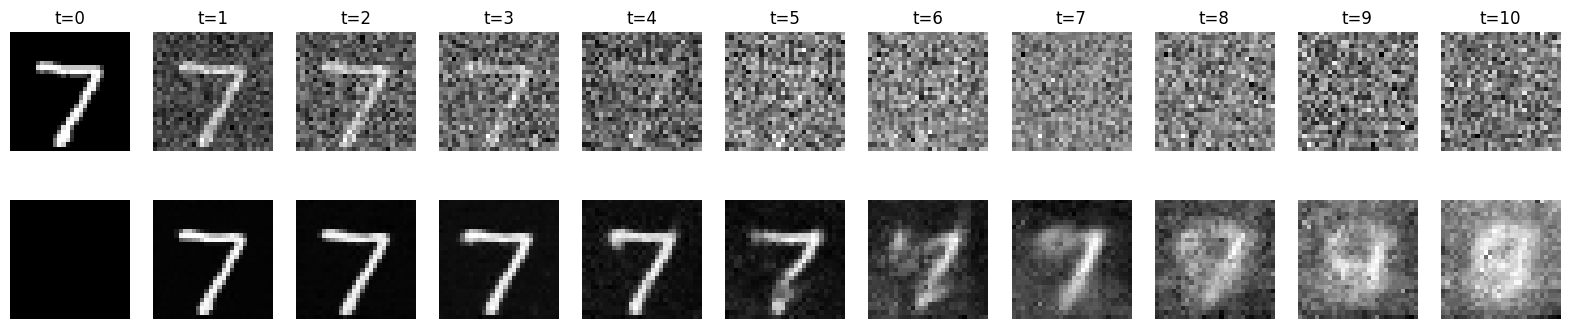

In [62]:
### A COMPLETER ###
# On prend une image de la base de donnée de test (jamais vue par le réseau) comme point de départ
x_0 = normalize(x_test[0])

# On prépare le vecteur des x_t que l'on va remplir au fur et à mesure
x = np.zeros((T+1, 28, 28))

# On prépare également le vecteur des x_0 débruités que l'on va remplir au fur et à mesure
denoised = np.zeros((T+1, 28, 28))


plt.figure(figsize=(20, 4))

for t in range(T+1):
  if t==0:
    x[t] = x_0
  else:
    # Echantillonnage d'un bruit gaussien epsilon
    epsilon = np.random.normal(0, 1, (28, 28))

    # Calcul de x_t à partir de x_{t-1}
    x[t] = np.sqrt(alpha[t])*x[t-1] + np.sqrt(beta[t])*epsilon

    # Prédiction du bruit présent dans x_t par le réseau
    epsilon_theta_xt_t = model.predict([np.reshape(x[t],(1,28,28,1)), np.reshape(t/T,(1,1))])[0,:,:,0]

    # Débruitage de l'image pour essayer de retrouver x_0
    denoised[t] = (x[t] - np.sqrt(1 - alpha_barre[t]) * epsilon_theta_xt_t) / np.sqrt(alpha_barre[t])

  plt.subplot(2, T+1, t+1)
  plt.title(f't={t}')
  plt.imshow(x[t], cmap='gray')
  plt.axis('off')

  plt.subplot(2, T+1, T+1 + t+1)
  plt.imshow(denoised[t], cmap='gray')
  plt.axis('off')

plt.show()



Si votre modèle a bien appris, l'image orginelle devrait être presque parfaitement retrouvée jusqu'à environ $t=5$, et on devrait même reconnaître le chiffre jusqu'à $t=7$.

## Échantillonnage de nouvelles images à partir d'un bruit

Il reste à implémenter la génération à proprement parler, avec l'algorithme suivant :

<center> <img src="https://drive.google.com/uc?id=12pwKwswKSnPXfxv9c4hevW-embVvLJRt" width=500></center>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


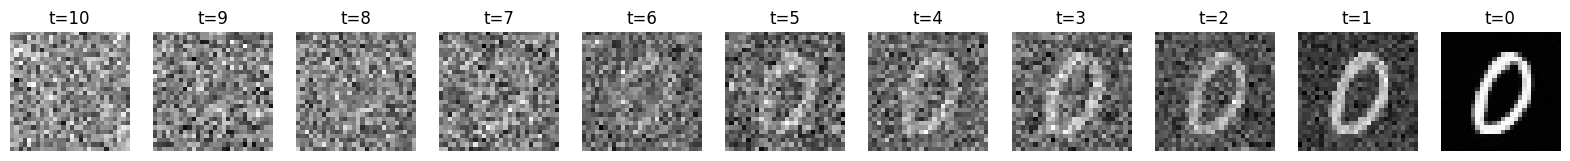

In [67]:
### A COMPLETER ###
# Echantillonnage d'un bruit gaussien comme point de départ
x_T = np.random.normal(0, 1, (28, 28))

# On prépare le vecteur des x_t que l'on va remplir au fur et à mesure, mais cette
# fois ci de T à 0
x = np.zeros((T+1, 28, 28))
x[T] = x_T


plt.figure(figsize=(20, 5))


for t in range(T,0,-1) :
  if t>1:
    # Echantillonnage d'un bruit gaussien z
    z = np.random.normal(0, 1, (28, 28))
  else:
    # A la fin, on positionne z comme une matrice de zéros
    z = np.zeros((28,28))

  # Prédiction du bruit présent dans x_t par le réseau
  epsilon_theta_xt_t = model.predict([np.reshape(x[t],(1,28,28,1)), np.reshape(t/T,(1,1))])[0,:,:,0]

  # Génération d'un x_{t-1} à partir de x_t et z
  x[t-1] = z*(1-alpha_barre[t]) + (x[t] - epsilon_theta_xt_t * (1-alpha[t])/np.sqrt(1-alpha[t]))/np.sqrt(alpha[t])

  plt.subplot(1, T+1, T+1 - t)
  plt.title(f't={t}')
  plt.imshow(x[t], cmap='gray')
  plt.axis('off')


plt.subplot(1, T+1, T+1)
plt.title(f't={0}')
plt.imshow(x[0], cmap='gray')
plt.axis('off')

plt.show()

Le bloc suivant vous permettra de générer directement 50 images, afin d'avoir une idée de la qualité (ou de la médiocrité !) générale de la génération

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 679ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


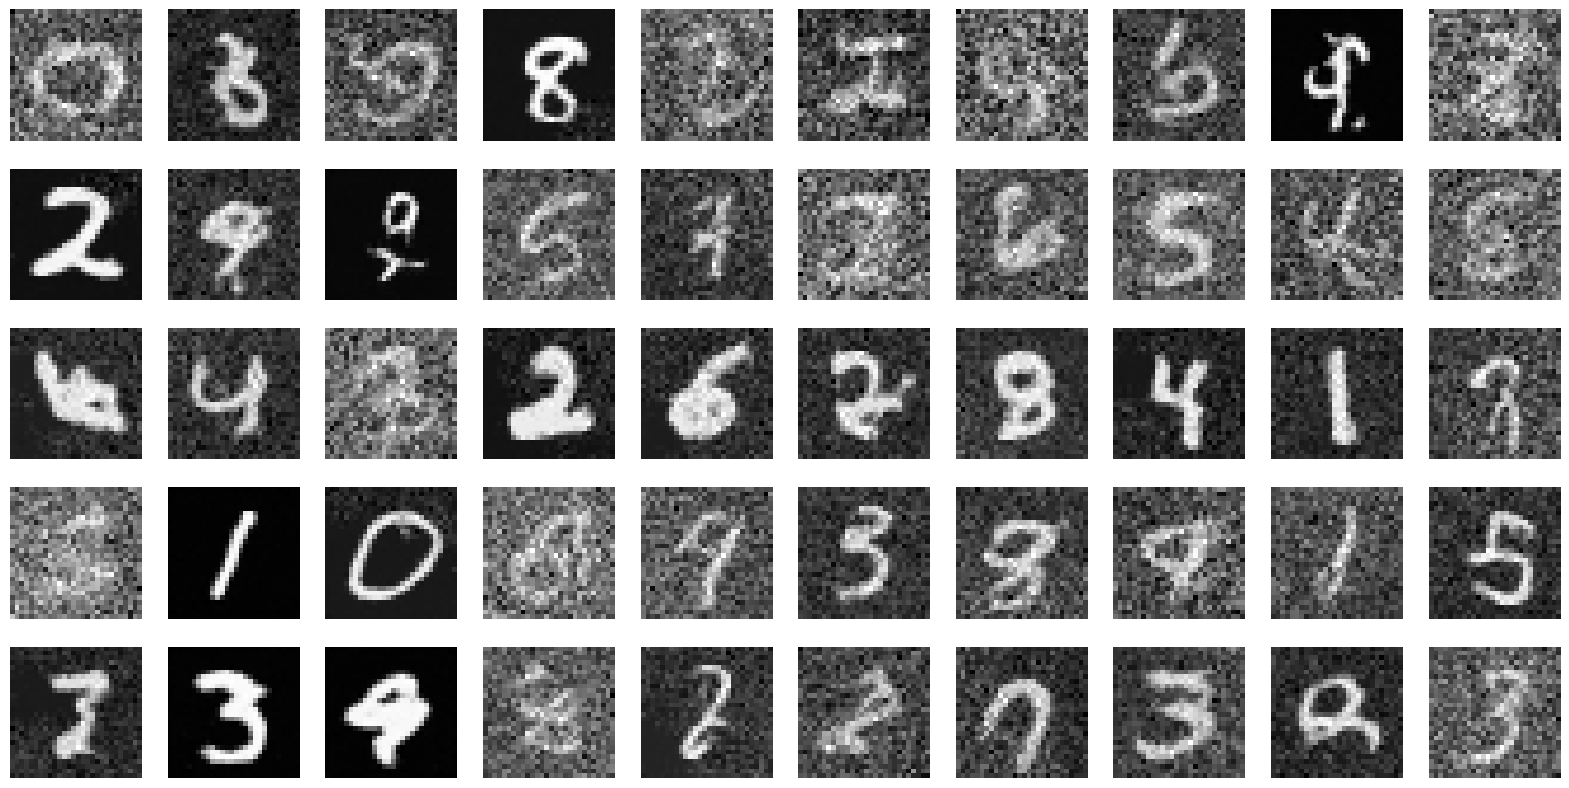

In [70]:
### A COMPLETER ###
# Création de 50 images de bruit de taille 28x28 simultanément
x_T = np.random.normal(0, 1, (50, 28, 28))

# Cette fois-ci, inutile de conserver les générations intermédiaires
# On va mettre à jour la variable x_t à chaque étape de la diffusion inverse
x_t = x_T

for t in range(T, 0, -1) :
  if t>1:
    # Echantillonnage d'un bruit gaussien z
    z = np.random.normal(0, 1, (50, 28, 28))
  else:
    # A la fin, on positionne z comme une matrice de zéros
    z = np.zeros((50,28,28))

  # Prédiction du bruit présent dans x_t par le réseau
  epsilon_theta_xt_t = model.predict([np.reshape(x_t,(50,28,28,1)), np.ones((50,1))*t/T])[:,:,:,0]

  # Génération d'un x_{t-1} à partir de x_t et z
  x_t = z*(1-alpha_barre[t]) + (x_t - epsilon_theta_xt_t * (1-alpha[t])/np.sqrt(1-alpha[t]))/np.sqrt(alpha[t])

plt.figure(figsize=(20, 10))

for i in range(50):
  plt.subplot(5, 10, i+1)
  plt.imshow(x_t[i], cmap='gray')
  plt.axis('off')

plt.show()

Si votre génération n'est pas satisfaisante, il est possible que les 20 epochs n'aient pas été suffisantes pour bien entraîner votre réseau. N'hésitez pas à relancer l'apprentissage un peu plus longtemps.

**Exercice complémentaire** :

Si jamais vous terminez rapidement, il reste une dernière chose intéressante à implémenter : la génération conditionnelle. Plutôt que de générer un chiffre au hasard, on peut conditionner la génération en fournissant une 3e entrée au réseau : le label que l'on veut générer. Comme on dispose de la variable y_train, il est facile de modifier la Sequence pour ajouter cette 3e entrée. Il vous faudra ensuite modifier le UNet et les codes de génération pour prendre en compte cette nouvelle entrée.